In [10]:
import os
import sys
import time
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from PIL import Image
import torch.nn as nn

In [35]:
def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

In [36]:
def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [37]:
content_image_file = "./content.jpeg"
content_size = 512

style_image_file = "./style.jpg"
style_size = 512

content_image = tensor_load_rgbimage(content_image_file, size=content_size, keep_asp=True)
content_image = content_image.unsqueeze(0)

style = tensor_load_rgbimage(style_image_file, size=style_size)
style = style.unsqueeze(0)
style = preprocess_batch(style)

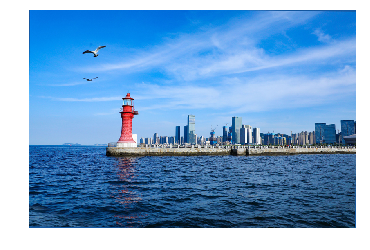

In [38]:
import matplotlib.pyplot as plt

def show_image(image_file):
    image = Image.open(image_file)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


show_image(content_image_file)

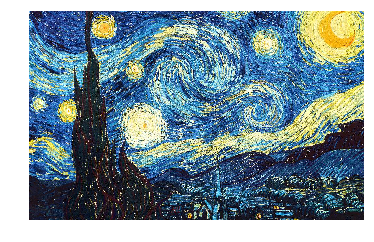

In [39]:
show_image(style_image_file)

In [40]:
def var(x, dim=0):
    '''
    Calculates variance.
    '''
    x_zero_meaned = x - x.mean(dim).expand_as(x)
    return x_zero_meaned.pow(2).mean(dim)


class MultConst(nn.Module):
    def forward(self, input):
        return 255*input


class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram
    

class Basicblock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Basicblock, self).__init__()
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes,
                                                        kernel_size=1, stride=stride)
        conv_block=[]
        conv_block+=[norm_layer(inplanes),
                                nn.ReLU(inplace=True),
                                ConvLayer(inplanes, planes, kernel_size=3, stride=stride),
                                norm_layer(planes),
                                nn.ReLU(inplace=True),
                                ConvLayer(planes, planes, kernel_size=3, stride=1),
                                norm_layer(planes)]
        self.conv_block = nn.Sequential(*conv_block)
    
    def forward(self, input):
        if self.downsample is not None:
            residual = self.residual_layer(input)
        else:
            residual = input
        return residual + self.conv_block(input)
            

class UpBasicblock(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBasicblock, self).__init__()
        self.residual_layer = UpsampleConvLayer(inplanes, planes,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block=[]
        conv_block+=[norm_layer(inplanes),
                                nn.ReLU(inplace=True),
                                UpsampleConvLayer(inplanes, planes, kernel_size=3, stride=1, upsample=stride),
                                norm_layer(planes),
                                nn.ReLU(inplace=True),
                                ConvLayer(planes, planes, kernel_size=3, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
    
    def forward(self, input):
        return self.residual_layer(input) + self.conv_block(input)


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes * self.expansion,
                                                        kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes * self.expansion,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return  self.residual_layer(x) + self.conv_block(x)


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1,C,C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B,C,C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G),self.G)
        return torch.bmm(self.P.transpose(1,2).expand(X.size(0), self.C, self.C), X.view(X.size(0),X.size(1),-1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'N x ' + str(self.C) + ')'

In [41]:
class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]

In [42]:
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [43]:
ngf = 128
style_model = Net(ngf=ngf)

model = "models/21styles.model"
model_dict = torch.load(model)
model_dict_clone = model_dict.copy()

In [44]:
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    style_model.cuda()
    content_image = content_image.cuda()
    style = style.cuda()

In [46]:
def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

In [47]:
def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)

In [48]:
style_v = Variable(style)
content_image = Variable(preprocess_batch(content_image))
style_model.setTarget(style_v)
output = style_model(content_image)

#output = utils.color_match(output, style_v)

output_image_file = "./output.jpg"
tensor_save_bgrimage(output.data[0], output_image_file, True if device == "cuda" else False)

/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


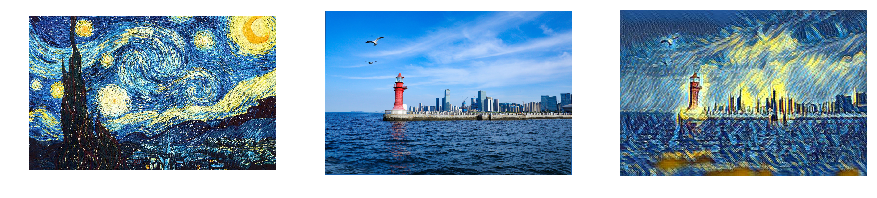

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

image_files = [style_image_file, content_image_file, "output.jpg"]
images = [Image.open(file) for file in image_files]

plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.axis("off")

plt.show()